# testing for molecules with 2+ charge with 2NH$_3$  

Final SMILES: [H][C]([H])([C]([H])([H])[N+]([H])([H])[H])[C]([H])([H])[N+]([H])([H])[H].[I-]


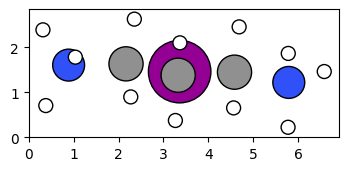

Nitrogen atom at index 2 has the highest number of bonded neighbors: 5
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 5
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


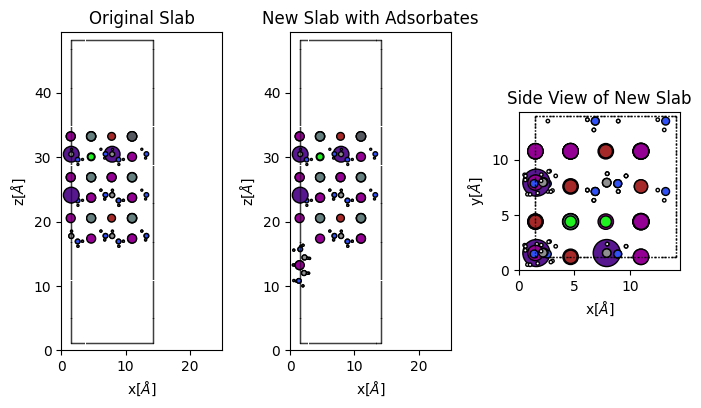

Saved new slab structure to Hong_passivation_mixed/PDAI.png_slab.vasp


In [39]:
import os
import random
from DECIMER import predict_SMILES
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
from rdkit import Chem
from rdkit.Chem import AllChem
from ase.io import read, write 
import matplotlib.pyplot as plt
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np
from ase import io, Atoms
from ase.visualize.plot import plot_atoms
from ase.atoms import Atoms
from ase.neighborlist import natural_cutoffs
from ase.build import sort
from ase.neighborlist import NeighborList
from ase.visualize import *
from ase.io import *
from ase.io.cif import read_cif
from ase.io.vasp import write_vasp
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from ase.build import bulk, surface
from ase.build.tools import sort
import random
from ase.build import molecule
from ase.neighborlist import NeighborList

from rdkit.Chem import rdmolops


# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
    # Add more atomic radii as needed
}

def nitrogen_with_most_bonds(molecule):
    """
    Find the nitrogen atom with the highest number of bonds.

    Args:
        molecule: An ASE Atoms object.

    Returns:
        Tuple containing the index of the nitrogen atom with the highest number of bonds
        and the number of bonds. Returns (None, 0) if no nitrogen atoms are found.
    """
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    
    if not nitrogen_indices:
        print('Nitrogen not found')
        return None, 0  # Return (None, 0) if no nitrogen atoms are found
    
    max_bond_count = 0
    nitrogen_index_with_most_bonds = None

    # Create a neighbor list
    cutoff_distance = natural_cutoffs(molecule)
    nl = NeighborList(cutoff_distance, self_interaction=False, bothways=True)
    nl.update(molecule)

    for i in nitrogen_indices:
        # Get neighbors of the nitrogen atom
        neighbors = nl.get_neighbors(i)[0]
        bond_count = len(neighbors)  # Count the number of bonded neighbors
    
        # Track nitrogen index with the most bonds
        if bond_count > max_bond_count:
            max_bond_count = bond_count
            nitrogen_index_with_most_bonds = i

    return nitrogen_index_with_most_bonds, max_bond_count


def rotate_molecule_towards_target(molecule, target_position):
    """
    Rotate the molecule so that nitrogen atoms are oriented towards the target position.
    
    Args:
        molecule: An ASE Atoms object.
        target_position: The position to orient the nitrogen atoms towards.
    """
    # Find nitrogen with the highest number of hydrogen neighbors
    #nh_index, hydrogen_count = nitrogen_with_highest_hydrogens(molecule)
    
    nh_index, max_bond_count = nitrogen_with_most_bonds(molecule)
    

    if nh_index is not None:
        print(f"Nitrogen atom at index {nh_index} has the highest number of bonded neighbors: {max_bond_count}")
    else:
        print("No nitrogen atoms found.")
    
    # Additional rotation logic goes here
    
    # For now, we only print the nh_index
    print(f"Index of nitrogen with most hydrogens: {nh_index}")
    
    # Calculate the average position of nitrogen atoms
    nitrogen_positions = molecule.positions[[nh_index]]
    avg_nitrogen_pos = np.mean(nitrogen_positions, axis=0)

    # Vector from average nitrogen position to target position    
    direction = target_position - avg_nitrogen_pos
    direction[2] = 0  # Only consider x-y plane for rotation
    direction /= np.linalg.norm(direction)

    # Define the direction we want the nitrogen to face (downward)
    target_direction = np.array([0, 0, 1])  # Pointing down

    # Calculate the angle between the current direction and target direction
    angle = np.arccos(np.clip(np.dot(direction, target_direction), -1.0, 1.0))
    
    #print(angle)
    #print(direction)
    
    # Axis of rotation (cross product)
    rotation_axis = np.cross(direction, target_direction)
    if np.linalg.norm(rotation_axis) == 0:
        print('No rotation needed')
        return  # No rotation needed

    rotation_axis /= np.linalg.norm(rotation_axis)
    
    # Create rotation matrix using Rodrigues' rotation formula
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0]**2 * (1 - cos_angle),
         rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle,
         rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle,
         cos_angle + rotation_axis[1]**2 * (1 - cos_angle),
         rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle,
         rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle,
         cos_angle + rotation_axis[2]**2 * (1 - cos_angle)]
    ])

    # Rotate the molecule
    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()

def position_and_rotate_molecule(molecule, slab_position, atomic_radii):
    """Positions and rotates the molecule to bring nitrogen atoms closer to the slab."""
    # Calculate target position for nitrogen atoms
    slab_top = slab_position[2] + atomic_radii['C']  # Top of Cs
    target_z = slab_top + atomic_radii['N'] + 1.0  # Add buffer
    target_position = np.array([slab_position[0], slab_position[1], target_z])
    
    # Move the molecule's center of mass to the target position
    center_of_mass = molecule.get_center_of_mass()
    molecule.positions += target_position - center_of_mass


    # Rotate the molecule
    rotate_molecule_towards_target(molecule, target_position)


    # Ensure no penetration into the slab
    for atom in molecule:
        if atom.position[2] < slab_top:
            print("Molecule penetrates the slab. Adjusting...")
            adjustment = slab_top - atom.position[2] -0.1 # Additional space
            molecule.positions[:, 2] += adjustment
            break  # Adjust only once for simplicity

    return molecule

def automate_adsorption(slab_file, molecule_file, num_replace_FA, output_file=None):
    """Automates the adsorption process by replacing specified number of C atoms in a slab with a given molecule."""
    try:
        relaxed_slab = io.read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        molecule = molecule_file
        tmp_molecule = []

        for j in range(num_replace_FA):
            num_atoms = len(relaxed_slab.get_chemical_symbols())
            FA_index = [(relaxed_slab.positions[i, 2], i) 
                         for i in range(num_atoms) 
                         if relaxed_slab.get_chemical_symbols()[i] == 'C']

            if not FA_index:
                print("No FA molecules found for replacement.")
                break

            # Get the index of the C atom with the maximum z value
            max_value_z, idz = max(FA_index, key=lambda item: item[0])
            #print(max_value_z, idz)

            

            # Position and rotate the molecule
            slab_position = relaxed_slab.positions[idz]
            #print(slab_position)

            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position, atomic_radii)

            # Store the positioned molecule and remove the replaced Cs atom
            tmp_molecule = positioned_molecule if j == 0 else tmp_molecule + positioned_molecule

            species='C'

            atom_indices = [i for i, atom in enumerate(relaxed_slab) if atom.symbol == species]
            replacements = random.sample(atom_indices, min(1, len(atom_indices)))
            cutoff_distance=1.2
            nl = NeighborList([cutoff_distance] * len(relaxed_slab), self_interaction=False, bothways=True)
            nl.update(relaxed_slab)
        
            del_indices = []
            for idx in replacements:
                indices, _ = nl.get_neighbors(idz)
                for j in indices:
                    if relaxed_slab[j].symbol == 'N':
                        del_indices.append(j)
                        # Check neighbors of N
                        ind_1, _ = nl.get_neighbors(j)
                        del_indices.extend([k for k in ind_1 if relaxed_slab[k].symbol == 'H'])
               
        
            del relaxed_slab[del_indices]
            del relaxed_slab[idz]

        # Combine the relaxed slab and the new molecule
        new_slab = relaxed_slab + tmp_molecule
        # Visualize the structures
        fig, axes = plt.subplots(1, 3, figsize=(7, 7))
        visualize_structure(slab_file, new_slab, axes)

        # Save the final structure to a VASP file if specified
        if output_file:
            io.write(output_file, new_slab, vasp5=True, direct=True)
            print(f"Saved new slab structure to {output_file}")

    except Exception as e:
        print(f"An error occurred during the process: {e}")

def visualize_structure(slab_file, new_slab, axes):
    """Visualizes the original and new slab structures."""
    slab = io.read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_xlim(0, 25)
    axes[0].set_xlabel(r'x[$\AA$]')
    axes[0].set_ylabel(r'z[$\AA$]')
    axes[0].set_title('Original Slab')

    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_xlim(0, 25)
    axes[1].set_xlabel(r'x[$\AA$]')
    axes[1].set_ylabel(r'z[$\AA$]')
    axes[1].set_title('New Slab with Adsorbates')

    plot_atoms(new_slab, axes[2], radii=0.5, rotation=('0x,0y,0z'))
    axes[2].set_xlabel(r'x[$\AA$]')
    axes[2].set_ylabel(r'y[$\AA$]')
    axes[2].set_title('Side View of New Slab')
    #view(new_slab)
    plt.tight_layout()
    plt.show()



def SmilesToMol(smiles):
    """
    Converts a SMILES string to an RDKit molecule, adds hydrogens,
    embeds the molecule in 3D space, and optimizes it.
    
    Args:
        smiles (str): SMILES representation of the molecule.
    
    Returns:
        mol: An RDKit Mol object if successful, otherwise None.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Failed to create molecule from SMILES: {smiles}")
        return None
    
    # Add hydrogens to the molecule
    hmol = Chem.AddHs(mol)
    
    # Embed molecule in 3D space
    AllChem.EmbedMolecule(hmol)
    
    # Optimize the 3D structure
    AllChem.MMFFOptimizeMolecule(hmol)
    
    return hmol



def MolToSmiles(mol, keep_hydrogens=True):
    if keep_hydrogens:
        return Chem.MolToSmiles(mol, allHsExplicit=True)  # Retain all explicit hydrogens in SMILES
    else:
        rdmolops.RemoveHs(mol)
        return Chem.MolToSmiles(mol)

def contains_nitrogen(mol):
    """
    Checks if the given molecule contains a nitrogen atom.
    
    Args:
        mol: An RDKit Mol object.
    
    Returns:
        bool: True if nitrogen is present, False otherwise.
    """
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())


# Function to check if an atom is nitrogen and bonded to exactly 4 atoms
def is_nitrogen_bonded_to_four(atom):
    return atom.GetSymbol() == 'N' and atom.GetDegree() == 4

# Function to check if a molecule has at least one iodine
def contains_iodine(mol):
    return any(atom.GetSymbol() == 'I' for atom in mol.GetAtoms())

# Function to check if a molecule contains any nitrogen
def contains_nitrogen(mol):
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())


def process_images_in_folder(folder_path):
    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):  # Change this if you need other formats
            image_path = os.path.join(folder_path, filename)

            # Predict SMILES from the image
            SMILES = predict_SMILES(image_path)
            split_smiles = SMILES.split(sep='.')
            
            # Find the first fragment containing nitrogen
            organic_mol = None
            for smiles_fragment in split_smiles:
                mol = SmilesToMol(smiles_fragment)
                if mol and contains_nitrogen(mol):
                    organic_mol = mol
                    break

            # Predict SMILES from the image
            SMILES = predict_SMILES(image_path)
            split_smiles = SMILES.split(sep='.')

            # Initialize variables to store fragments
            organic_mol = None
            iodine_mol = None

            # Loop through fragments to find a candidate that meets criteria
            for smiles_fragment in split_smiles:
                mol = SmilesToMol(smiles_fragment)

                if mol and contains_nitrogen(mol):
                    # Count nitrogen atoms bonded to four atoms
                    nitrogens_bonded_to_four = sum(1 for atom in mol.GetAtoms() if is_nitrogen_bonded_to_four(atom))

                    # Check if this fragment has exactly two nitrogen atoms bonded to four atoms
                    if nitrogens_bonded_to_four == 2:
                        # If it also has iodine, select it as the primary fragment
                        if contains_iodine(mol):
                            organic_mol = mol  # Keep this fragment with one iodine
                            break
                        else:
                            organic_mol = mol  # Keep this as temporary if no iodine found

            # If no iodine-containing fragment was found, select any nitrogen-containing fragment as fallback
            if organic_mol is None:
                for smiles_fragment in split_smiles:
                    mol = SmilesToMol(smiles_fragment)
                    if mol and contains_nitrogen(mol):
                        organic_mol = mol  # Keep the first nitrogen-containing fragment as fallback
                        break

            # Check if there's a separate iodine fragment and combine if necessary
            for smiles_fragment in split_smiles:
                mol = SmilesToMol(smiles_fragment)
                if mol and contains_iodine(mol) and mol != organic_mol:
                    iodine_mol = mol
                    break

            # Merge iodine with organic fragment if needed
            if iodine_mol and organic_mol:
                combined_mol = Chem.CombineMols(organic_mol, iodine_mol)
                rdmolops.AddHs(combined_mol)  # Preserve hydrogens
                output_SMILES = MolToSmiles(combined_mol, keep_hydrogens=True)
            else:
                output_SMILES = MolToSmiles(organic_mol, keep_hydrogens=True)

            # Final SMILES for the selected fragment with one iodine (if found) and no duplicates
            if output_SMILES:
                print("Final SMILES:", output_SMILES)
            else:
                raise ValueError("No suitable fragment containing nitrogen was found.")

            organic_mol = SmilesToMol(output_SMILES)
            #print(organic_mol)



#             if organic_mol is None:
#                 raise ValueError("No organic fragment containing nitrogen was found.")

            # Save the organic fragment containing nitrogen to a .mol file
            Chem.MolToMolFile(organic_mol, f'{filename}_test.mol')

            # Read the .mol file with ASE
            molecule = read(f'{filename}_test.mol')

            # Plot the molecule
            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            plot_atoms(molecule, axes, radii=0.5, rotation=('0x,0y,0z'))
            plt.show()

            # Perform adsorption automation (you may want to customize this)
            # Define the folder where you want to save the output
            output_folder = 'Hong_passivation_mixed'

            # Create the folder if it does not exist
            os.makedirs(output_folder, exist_ok=True)

            # Define the output file path
            output_file = os.path.join(output_folder, f'{filename}_slab.vasp')
            
            automate_adsorption('surface_001.vasp', molecule, num_replace_FA=2, output_file=output_file)

            # Load the slab for visualization
            #slab = read(output_file)
            #view(slab, viewer='ngl')

# Example usage
folder_path = "./test_N2+/"
process_images_in_folder(folder_path)

In [40]:
# Load the slab for visualization
slab = read('Hong_passivation_mixed/PDAI.png_slab.vasp')
view(slab, viewer='ngl')

In [ ]:
atoms = read(output_file)
view(atoms)

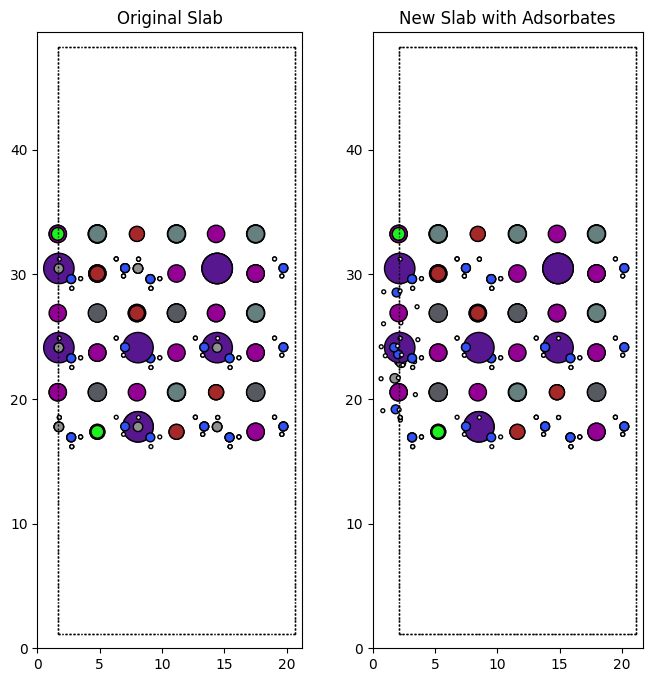

Saved modified slab to Hong_passivation_mixed/PDAI.png_slab.vasp


In [6]:
from ase.visualize import view
# Load the slab for visualization
slab = read('Hong_passivation_mixed/PDAI.png_slab.vasp')
view(slab, viewer='ngl')

In [54]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import AllChem
from ase import Atoms
from ase.visualize import view

# Step 1: Convert SMILES string to a molecule
def SmilesToMol(smiles):
    """Convert SMILES to a molecule object, adding explicit hydrogens."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Add explicit hydrogens to the molecule to resolve the warning
        rdmolops.AddHs(mol)  
    return mol

# Step 2: Add iodine atom, close to nitrogen, respecting valency
def add_iodine_near_nitrogen(mol):
    """Add iodine near nitrogen atoms, ensuring nitrogen's valency is respected."""
    rw_mol = Chem.RWMol(mol)  # Create a mutable version of the molecule

    # Get all nitrogen atoms
    nitrogens = [atom for atom in rw_mol.GetAtoms() if atom.GetSymbol() == 'N']

    # Add iodine atom (as an ion or neutral)
    iodine_atom = Chem.Atom("I")
    iodine_idx = rw_mol.AddAtom(iodine_atom)

    # Try to place iodine near the first nitrogen (considering valency)
    for nitrogen in nitrogens:
        nitrogen_idx = nitrogen.GetIdx()

        # Check if nitrogen has less than 3 bonds (this is the max normal bonding for nitrogen)
        if rw_mol.GetAtomWithIdx(nitrogen_idx).GetDegree() < 3:  
            # Add a bond between iodine and nitrogen
            rw_mol.AddBond(nitrogen_idx, iodine_idx, Chem.BondType.SINGLE)
            break
    else:
        # If no suitable nitrogen found, add iodine as a lone ion
        print("No nitrogen suitable for bonding, iodine added as an isolated ion.")

    return rw_mol

# Step 3: Generate 3D coordinates
def generate_3d_coordinates(mol):
    """Generate 3D coordinates for the molecule using RDKit."""
    # Use ETKDG to generate 3D coordinates
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol)  # Optional: minimize geometry
    
    return mol

# Step 4: Convert RDKit molecule to ASE Atoms object
def mol_to_ase_atoms(mol):
    """Convert an RDKit molecule to an ASE Atoms object."""
    symbols = []
    positions = []
    
    # Retrieve atom symbols and positions from the molecule
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        symbols.append(symbol)
        positions.append([pos.x, pos.y, pos.z])
    
    # Create ASE Atoms object from atom symbols and positions
    ase_atoms = Atoms(symbols=symbols, positions=positions)
    return ase_atoms

# Step 5: Save the molecule to a .mol file
def save_mol_file(mol, file_path):
    """Save the RDKit molecule to a .mol file."""
    with open(file_path, 'w') as f:
        f.write(Chem.MolToMolBlock(mol))

# Step 6: Visualization
def visualize_molecule(mol):
    """Visualize the molecule using ASE."""
    ase_atoms = mol_to_ase_atoms(mol)
    view(ase_atoms)

# Main function to process the molecule
def main(smiles, output_file):
    # Step 1: Convert the SMILES string to a molecule object
    mol = SmilesToMol(smiles)

    # Step 2: Add iodine close to nitrogen (ensure valency is respected)
    mol_with_iodine = add_iodine_near_nitrogen(mol)

    # Step 3: Generate 3D coordinates for the molecule
    mol_with_iodine = generate_3d_coordinates(mol_with_iodine)

    # Step 4: Save the modified molecule to a .mol file
    save_mol_file(mol_with_iodine, output_file)

    print(f"Modified molecule saved to {output_file}")

    # Step 5: Visualize the molecule
    visualize_molecule(mol_with_iodine)

# Run the code
smiles = '[H][C]([H])([C]([H])([H])[N+]([H])([H])[H])[C]([H])([H])[N+]([H])([H])[H].[I-]'
output_file = "modified_molecule.mol"
main(smiles, output_file)


[12:21:18] Molecule does not have explicit Hs. Consider calling AddHs()
[12:21:18] Explicit valence for atom # 2 N, 4, is greater than permitted


AtomValenceException: Explicit valence for atom # 2 N, 4, is greater than permitted